1. Loading Data

In [ ]:
# !pip install pytorch-tabnet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import torch
# from pytorch_tabnet.tab_model import TabNetClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from collections import Counter
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.cluster import KMeans



In [ ]:
matches = pd.read_csv('/content/matches.csv')
deliveries = pd.read_csv('/content/deliveries.csv')

In [ ]:
matches.head()

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [ ]:
deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN


2. Data Cleaning and Feature Engineering

In [ ]:
matches.shape

(1095, 20)

In [ ]:
matches.isnull().sum()

,0
id,0
season,0
city,51
date,0
match_type,0
player_of_match,5
venue,0
team1,0
team2,0
toss_winner,0


In [ ]:
# Create a mapping of venue to city (excluding NaN values)
venue_to_city = matches.dropna(subset=['city']).groupby('venue')['city'].first().to_dict()

# Fill missing city values based on venue
matches['city'] = matches.apply(lambda row: venue_to_city.get(row['venue'], 'Unknown') if pd.isna(row['city']) else row['city'], axis=1)


In [ ]:
matches['city'].value_counts()

,count
city,
Mumbai,173
Kolkata,93
Delhi,90
Chennai,85
Hyderabad,77
Bangalore,65
Chandigarh,61
Jaipur,57
Pune,51


In [ ]:
matches[matches['winner'].isnull()]

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
241,501265,2011,Delhi,2011-05-21,League,NaN,Feroz Shah Kotla,Delhi Daredevils,Pune Warriors,Delhi Daredevils,bat,NaN,no result,NaN,NaN,NaN,N,NaN,SS Hazare,RJ Tucker
485,829763,2015,Bangalore,2015-04-29,League,NaN,M Chinnaswamy Stadium,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,NaN,no result,NaN,NaN,NaN,N,NaN,JD Cloete,PG Pathak
511,829813,2015,Bangalore,2015-05-17,League,NaN,M Chinnaswamy Stadium,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,field,NaN,no result,NaN,188.0,20.0,N,NaN,HDPK Dharmasena,K Srinivasan
744,1178424,2019,Bengaluru,2019-04-30,League,NaN,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,NaN,no result,NaN,63.0,5.0,N,NaN,NJ Llong,UV Gandhe
994,1359519,2023,Lucknow,2023-05-03,League,NaN,Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...,Lucknow Super Giants,Chennai Super Kings,Chennai Super Kings,field,NaN,no result,NaN,NaN,NaN,N,NaN,AK Chaudhary,NA Patwardhan


In [ ]:
#officially there is no winner of these matches
#we can go with this matches['winner'].fillna('No Winner', inplace=True)

matches['winner'].fillna('No Winner', inplace=True)

<ipython-input-13-0687445224b0>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  matches['winner'].fillna('No Winner', inplace=True)


In [ ]:
matches['player_of_match'].fillna('No player', inplace=True)

<ipython-input-14-807ede516f2c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  matches['player_of_match'].fillna('No player', inplace=True)


In [ ]:
matches[matches['result_margin'].isnull()]

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
66,392190,2009,Cape Town,2009-04-23,League,YK Pathan,Newlands,Kolkata Knight Riders,Rajasthan Royals,Kolkata Knight Riders,field,Rajasthan Royals,tie,NaN,151.0,20.0,Y,NaN,MR Benson,M Erasmus
130,419121,2009/10,Chennai,2010-03-21,League,J Theron,"MA Chidambaram Stadium, Chepauk",Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,field,Kings XI Punjab,tie,NaN,137.0,20.0,Y,NaN,K Hariharan,DJ Harper
241,501265,2011,Delhi,2011-05-21,League,No player,Feroz Shah Kotla,Delhi Daredevils,Pune Warriors,Delhi Daredevils,bat,No Winner,no result,NaN,NaN,NaN,N,NaN,SS Hazare,RJ Tucker
328,598004,2013,Hyderabad,2013-04-07,League,GH Vihari,"Rajiv Gandhi International Stadium, Uppal",Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,bat,Sunrisers Hyderabad,tie,NaN,131.0,20.0,Y,NaN,AK Chaudhary,S Ravi
342,598017,2013,Bangalore,2013-04-16,League,V Kohli,M Chinnaswamy Stadium,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,field,Royal Challengers Bangalore,tie,NaN,153.0,20.0,Y,NaN,M Erasmus,VA Kulkarni
416,729315,2014,Abu Dhabi,2014-04-29,League,JP Faulkner,Sheikh Zayed Stadium,Kolkata Knight Riders,Rajasthan Royals,Rajasthan Royals,bat,Rajasthan Royals,tie,NaN,153.0,20.0,Y,NaN,Aleem Dar,AK Chaudhary
475,829741,2015,Ahmedabad,2015-04-21,League,SE Marsh,"Sardar Patel Stadium, Motera",Rajasthan Royals,Kings XI Punjab,Kings XI Punjab,field,Kings XI Punjab,tie,NaN,192.0,20.0,Y,NaN,M Erasmus,S Ravi
485,829763,2015,Bangalore,2015-04-29,League,No player,M Chinnaswamy Stadium,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,No Winner,no result,NaN,NaN,NaN,N,NaN,JD Cloete,PG Pathak
511,829813,2015,Bangalore,2015-05-17,League,No player,M Chinnaswamy Stadium,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,field,No Winner,no result,NaN,188.0,20.0,N,NaN,HDPK Dharmasena,K Srinivasan
610,1082625,2017,Rajkot,2017-04-29,League,KH Pandya,Saurashtra Cricket Association Stadium,Gujarat Lions,Mumbai Indians,Gujarat Lions,bat,Mumbai Indians,tie,NaN,154.0,20.0,Y,NaN,AK Chaudhary,CB Gaffaney


In [ ]:
#result_margin values are missing if the match is tie or there is no winner so for both cases result margin will be 0
matches['result_margin'].fillna(0,inplace=True)

<ipython-input-16-ac3b3ae77a10>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  matches['result_margin'].fillna(0,inplace=True)


In [ ]:
matches[matches['target_runs'].isnull()]

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
241,501265,2011,Delhi,2011-05-21,League,No player,Feroz Shah Kotla,Delhi Daredevils,Pune Warriors,Delhi Daredevils,bat,No Winner,no result,0.0,NaN,NaN,N,NaN,SS Hazare,RJ Tucker
485,829763,2015,Bangalore,2015-04-29,League,No player,M Chinnaswamy Stadium,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,No Winner,no result,0.0,NaN,NaN,N,NaN,JD Cloete,PG Pathak
994,1359519,2023,Lucknow,2023-05-03,League,No player,Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...,Lucknow Super Giants,Chennai Super Kings,Chennai Super Kings,field,No Winner,no result,0.0,NaN,NaN,N,NaN,AK Chaudhary,NA Patwardhan


In [ ]:
deliveries[deliveries['match_id']==1359519]

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
236750,1359519,1,Lucknow Super Giants,Chennai Super Kings,0,1,M Vohra,DL Chahar,KR Mayers,1,0,1,NaN,0,NaN,NaN,NaN
236751,1359519,1,Lucknow Super Giants,Chennai Super Kings,0,2,KR Mayers,DL Chahar,M Vohra,0,0,0,NaN,0,NaN,NaN,NaN
236752,1359519,1,Lucknow Super Giants,Chennai Super Kings,0,3,KR Mayers,DL Chahar,M Vohra,0,0,0,NaN,0,NaN,NaN,NaN
236753,1359519,1,Lucknow Super Giants,Chennai Super Kings,0,4,KR Mayers,DL Chahar,M Vohra,0,0,0,NaN,0,NaN,NaN,NaN
236754,1359519,1,Lucknow Super Giants,Chennai Super Kings,0,5,KR Mayers,DL Chahar,M Vohra,0,0,0,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236863,1359519,1,Lucknow Super Giants,Chennai Super Kings,18,4,A Badoni,DL Chahar,K Gowtham,0,0,0,NaN,0,NaN,NaN,NaN
236864,1359519,1,Lucknow Super Giants,Chennai Super Kings,18,5,A Badoni,DL Chahar,K Gowtham,2,0,2,NaN,0,NaN,NaN,NaN
236865,1359519,1,Lucknow Super Giants,Chennai Super Kings,18,6,A Badoni,DL Chahar,K Gowtham,6,0,6,NaN,0,NaN,NaN,NaN
236866,1359519,1,Lucknow Super Giants,Chennai Super Kings,19,1,K Gowtham,M Pathirana,A Badoni,0,0,0,NaN,0,NaN,NaN,NaN


In [ ]:
# Only 3 out of 1095 rows are removed = Negligible data loss
matches.dropna(subset=['target_runs'], inplace=True)
matches.reset_index(drop=True, inplace=True)

In [ ]:
matches['method'].value_counts()

,count
method,
D/L,21


In [ ]:
#  97.8% missing values (1071 out of 1092) Irrelevant for most matches
#Best choice is to drop the column
matches.drop(columns=['method'],inplace=True)

In [ ]:
matches.isnull().sum()

,0
id,0
season,0
city,0
date,0
match_type,0
player_of_match,0
venue,0
team1,0
team2,0
toss_winner,0


In [ ]:
deliveries.isnull().sum()

,0
match_id,0
inning,0
batting_team,0
bowling_team,0
over,0
ball,0
batter,0
bowler,0
non_striker,0
batsman_runs,0


In [ ]:
deliveries['extras_type'].value_counts()

,count
extras_type,
wides,8380
legbyes,4001
noballs,1069
byes,673
penalty,2


In [ ]:
deliveries['extras_type'].fillna("noextra",inplace=True)

<ipython-input-25-eaac1fa1e2cf>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  deliveries['extras_type'].fillna("noextra",inplace=True)


In [ ]:
deliveries['player_dismissed'].fillna("NotOut",inplace=True)

<ipython-input-26-cf0abb6aeaa2>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  deliveries['player_dismissed'].fillna("NotOut",inplace=True)


In [ ]:
deliveries['dismissal_kind'].fillna('NotOut',inplace=True)

<ipython-input-27-835f7e875639>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  deliveries['dismissal_kind'].fillna('NotOut',inplace=True)


In [ ]:
deliveries['fielder'].value_counts()

,count
fielder,
MS Dhoni,220
KD Karthik,199
AB de Villiers,141
RV Uthappa,133
V Kohli,131
...,...
T Taibu,1
Kumar Kushagra,1
Younis Khan,1


In [ ]:
#either bowled or lbw
deliveries['fielder'].fillna('Nofielder',inplace=True)

<ipython-input-29-519f4158771b>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  deliveries['fielder'].fillna('Nofielder',inplace=True)


In [ ]:
deliveries.isnull().sum()

,0
match_id,0
inning,0
batting_team,0
bowling_team,0
over,0
ball,0
batter,0
bowler,0
non_striker,0
batsman_runs,0


In [ ]:
num_cols_matches = ['result_margin', 'target_runs', 'target_overs']

# Function to detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Detect outliers in matches dataset
for col in num_cols_matches:
    outliers_matches = detect_outliers_iqr(matches, col)
    print(f"Outliers in {col}:\n", outliers_matches)

Outliers in result_margin:
            id   season        city        date match_type player_of_match  \
0      335982  2007/08   Bangalore  2008-04-18     League     BB McCullum   
9      335991  2007/08  Chandigarh  2008-04-25     League   KC Sangakkara   
18     336000  2007/08      Jaipur  2008-05-01     League     SA Asnodkar   
39     336023  2007/08      Jaipur  2008-05-17     League        GC Smith   
54     336019  2007/08  Chandigarh  2008-05-28     League        SE Marsh   
...       ...      ...         ...         ...        ...             ...   
1055  1426273     2024       Delhi  2024-04-20     League         TM Head   
1066  1426284     2024     Chennai  2024-04-28     League      RD Gaikwad   
1074  1426292     2024     Lucknow  2024-05-05     League       SP Narine   
1078  1426296     2024  Dharamsala  2024-05-09     League         V Kohli   
1082  1426300     2024   Bengaluru  2024-05-12     League         C Green   

                                               

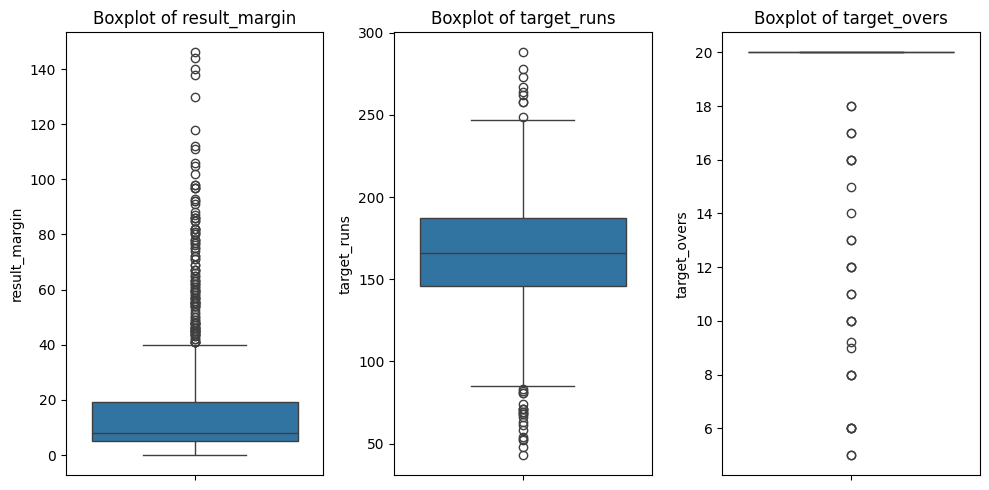

In [ ]:
plt.figure(figsize=(10, 5))

for i, col in enumerate(num_cols_matches):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=matches[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [ ]:
#high score runs are common in ipl so we are keeping the ouliers
def count_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers)

# Count outliers for each column using IQR
outliers_iqr_counts = {col: count_outliers_iqr(matches, col) for col in num_cols_matches}
print("Outliers Count (IQR Method):", outliers_iqr_counts)


Outliers Count (IQR Method): {'result_margin': 126, 'target_runs': 30, 'target_overs': 30}


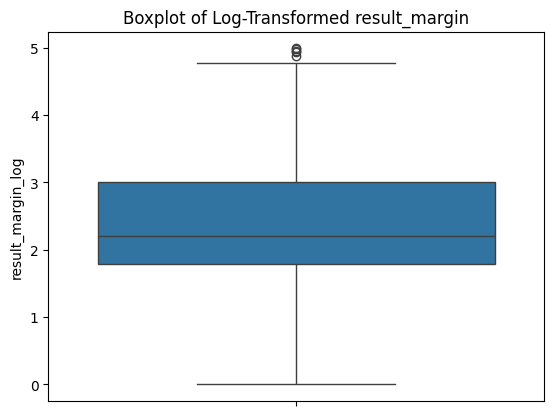

In [ ]:
#we have to consider both win by wickets or win by runs so transforming into log
matches['result_margin_log'] = np.log1p(matches['result_margin'])
sns.boxplot(y=matches['result_margin_log'])
plt.title("Boxplot of Log-Transformed result_margin")
plt.show()

In [ ]:
#five outlier we can keep
count_outliers_iqr(matches,"result_margin_log")

5

3. Exploratory Data Analysis (EDA)


*   Team Performance



<ipython-input-36-b8977a36bdce>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=winning_percentage.index, y=winning_percentage.values, palette='viridis')


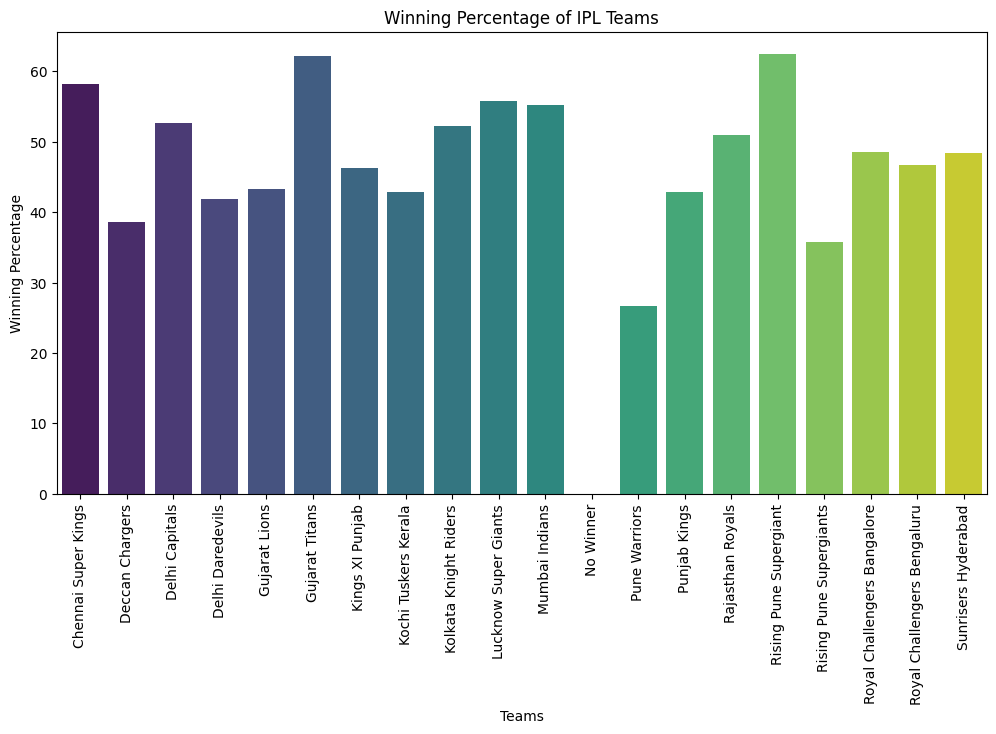

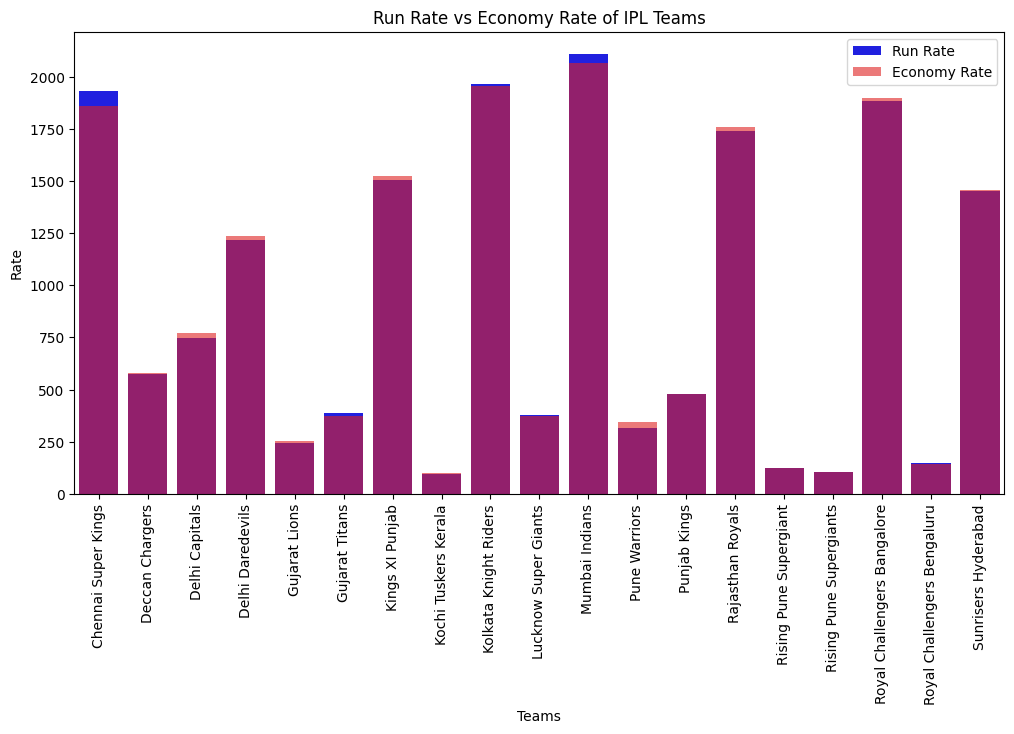

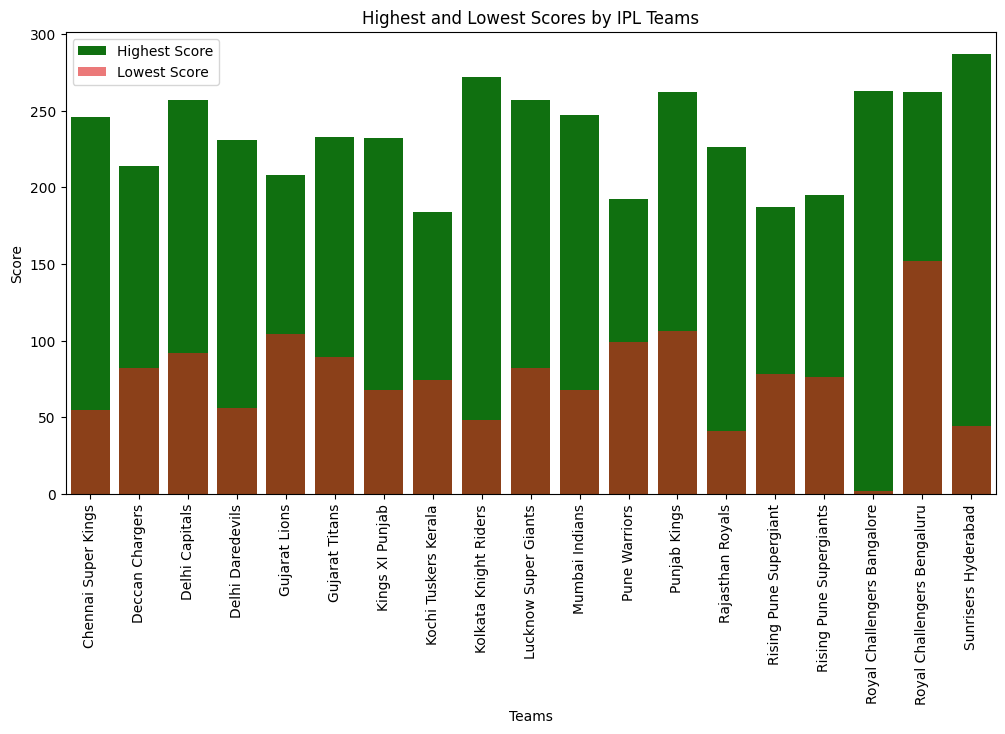

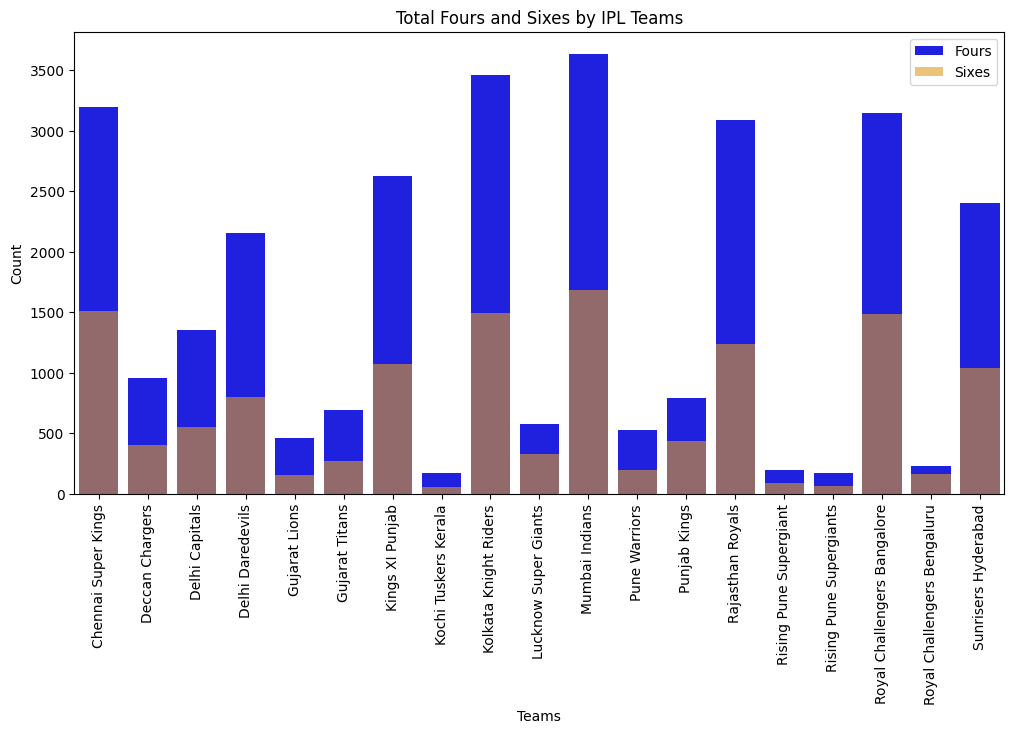

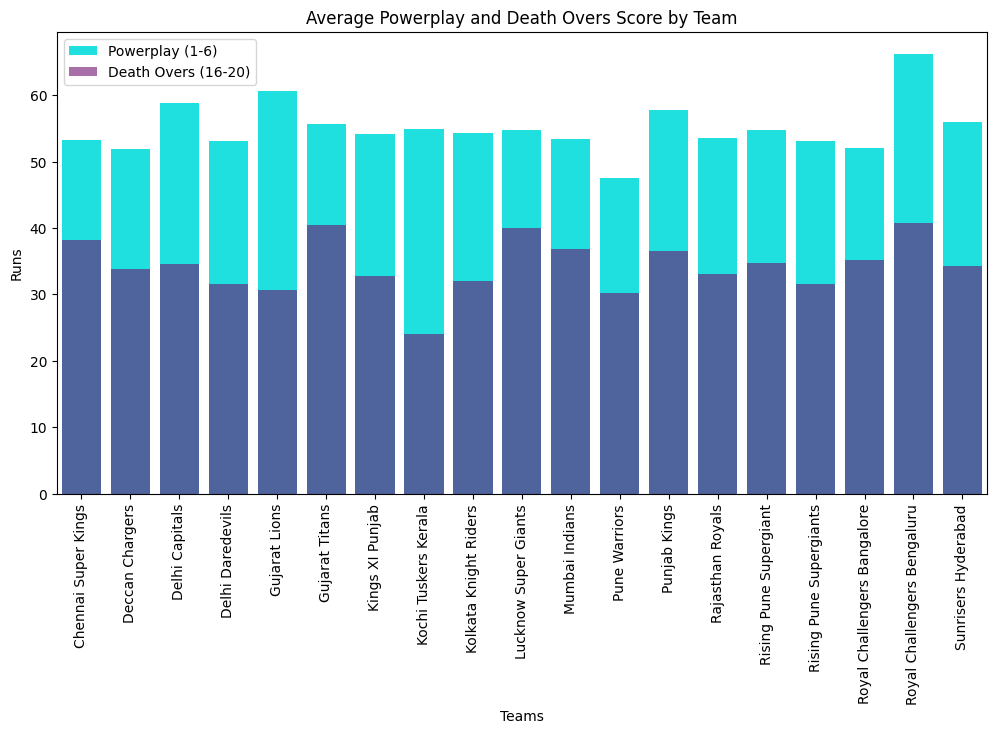

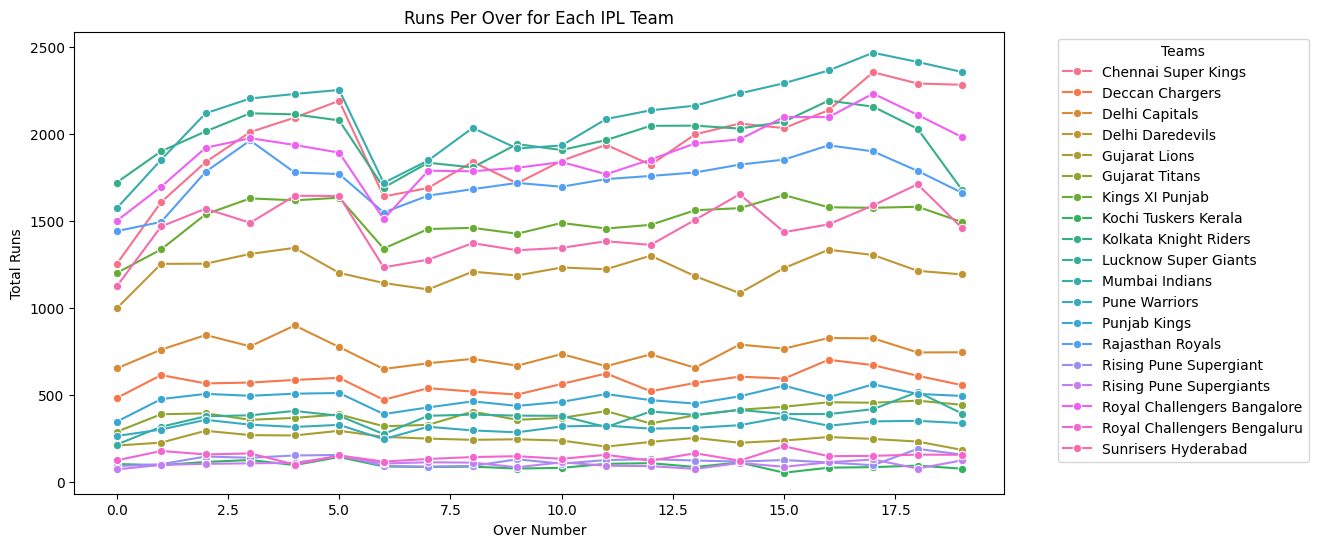

<ipython-input-36-b8977a36bdce>:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=powerplay_avg.index, y=powerplay_avg.values, palette='coolwarm')


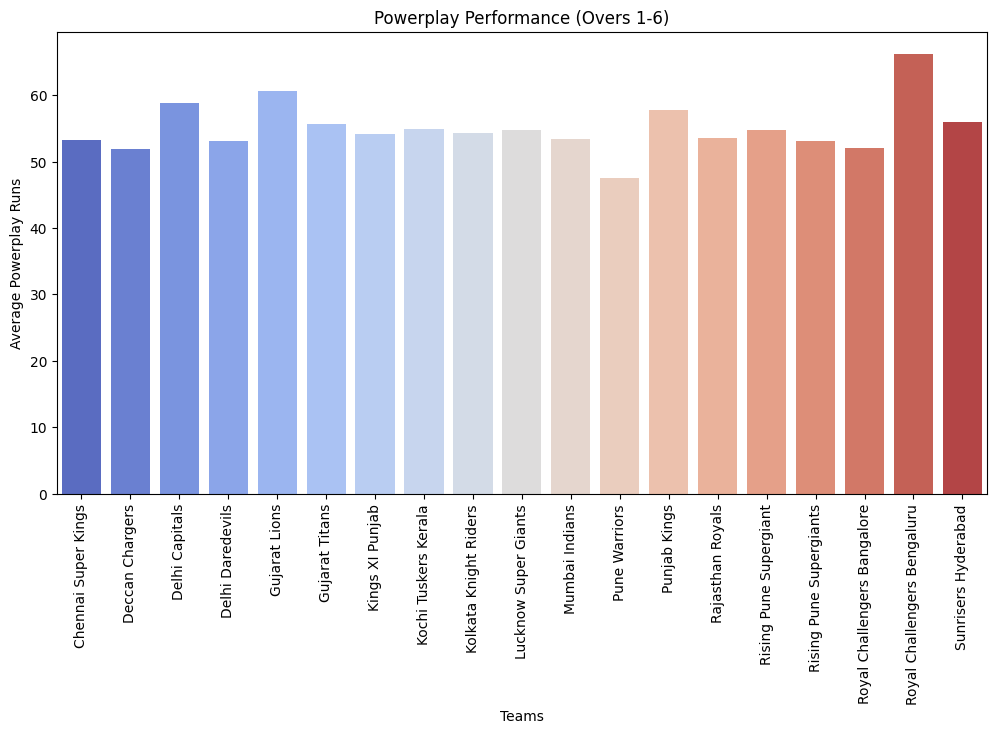

In [ ]:
# Count total matches played by each team
matches_played = pd.concat([matches['team1'], matches['team2']]).value_counts()

# Count matches won by each team
matches_won = matches['winner'].value_counts()

# Calculate winning percentage
winning_percentage = (matches_won / matches_played) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=winning_percentage.index, y=winning_percentage.values, palette='viridis')
plt.xticks(rotation=90)
plt.title("Winning Percentage of IPL Teams")
plt.xlabel("Teams")
plt.ylabel("Winning Percentage")
plt.show()


# Calculate total runs and overs for each team
total_runs = deliveries.groupby('batting_team')['total_runs'].sum()
total_overs = deliveries.groupby('batting_team')['over'].nunique()

# Compute Run Rate (Total Runs / Total Overs)
run_rate = total_runs / total_overs

# Compute Economy Rate (Runs Conceded / Overs Bowled)
total_runs_conceded = deliveries.groupby('bowling_team')['total_runs'].sum()
economy_rate = total_runs_conceded / total_overs

# Plot Run Rate and Economy Rate
plt.figure(figsize=(12, 6))
sns.barplot(x=run_rate.index, y=run_rate.values, color='blue', label='Run Rate')
sns.barplot(x=economy_rate.index, y=economy_rate.values, color='red', alpha=0.6, label='Economy Rate')
plt.xticks(rotation=90)
plt.title("Run Rate vs Economy Rate of IPL Teams")
plt.xlabel("Teams")
plt.ylabel("Rate")
plt.legend()
plt.show()


# Group matches by match_id and batting team to get match scores
team_scores = deliveries.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()

# Find the highest and lowest scores per team
highest_scores = team_scores.groupby('batting_team')['total_runs'].max()
lowest_scores = team_scores.groupby('batting_team')['total_runs'].min()

plt.figure(figsize=(12, 6))
sns.barplot(x=highest_scores.index, y=highest_scores.values, color='green', label='Highest Score')
sns.barplot(x=lowest_scores.index, y=lowest_scores.values, color='red', alpha=0.6, label='Lowest Score')
plt.xticks(rotation=90)
plt.title("Highest and Lowest Scores by IPL Teams")
plt.xlabel("Teams")
plt.ylabel("Score")
plt.legend()
plt.show()


# Count the number of 4s and 6s
fours = deliveries[deliveries['batsman_runs'] == 4].groupby('batting_team').size()
sixes = deliveries[deliveries['batsman_runs'] == 6].groupby('batting_team').size()

plt.figure(figsize=(12, 6))
sns.barplot(x=fours.index, y=fours.values, color='blue', label='Fours')
sns.barplot(x=sixes.index, y=sixes.values, color='orange', alpha=0.6, label='Sixes')
plt.xticks(rotation=90)
plt.title("Total Fours and Sixes by IPL Teams")
plt.xlabel("Teams")
plt.ylabel("Count")
plt.legend()
plt.show()


# Powerplay (Overs 1-6)
powerplay_scores = deliveries[(deliveries['over'] <= 6)].groupby('batting_team')['total_runs'].sum() / matches_played

# Death Overs (Overs 16-20)
death_overs_scores = deliveries[(deliveries['over'] >= 16)].groupby('batting_team')['total_runs'].sum() / matches_played

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=powerplay_scores.index, y=powerplay_scores.values, color='cyan', label='Powerplay (1-6)')
sns.barplot(x=death_overs_scores.index, y=death_overs_scores.values, color='purple', alpha=0.6, label='Death Overs (16-20)')
plt.xticks(rotation=90)
plt.title("Average Powerplay and Death Overs Score by Team")
plt.xlabel("Teams")
plt.ylabel("Runs")
plt.legend()
plt.show()


# Calculate runs per over for each team
runs_per_over = deliveries.groupby(['batting_team', 'over'])['total_runs'].sum().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=runs_per_over, x='over', y='total_runs', hue='batting_team', marker='o')
plt.title("Runs Per Over for Each IPL Team")
plt.xlabel("Over Number")
plt.ylabel("Total Runs")
plt.legend(title="Teams", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Powerplay data (overs 1-6)
powerplay = deliveries[(deliveries['over'] <= 6)]

# Average runs scored in powerplay per team
powerplay_avg = powerplay.groupby('batting_team')['total_runs'].sum() / matches_played

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=powerplay_avg.index, y=powerplay_avg.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Powerplay Performance (Overs 1-6)")
plt.xlabel("Teams")
plt.ylabel("Average Powerplay Runs")
plt.show()





*   Players Performance


<ipython-input-37-967f2318f6ec>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scorers['batter'], y=top_scorers['batsman_runs'], palette='magma')


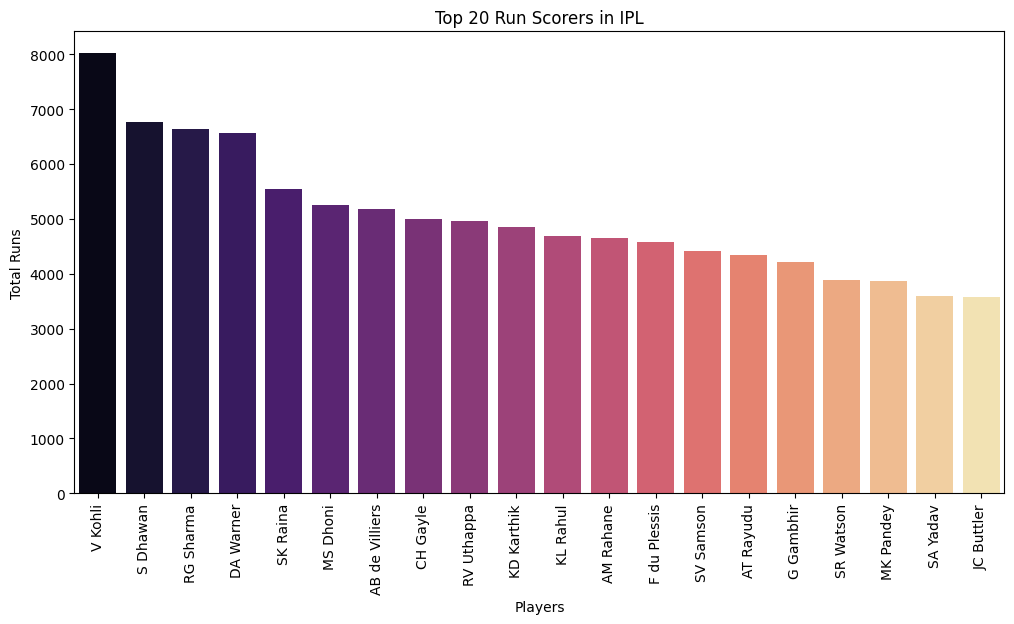

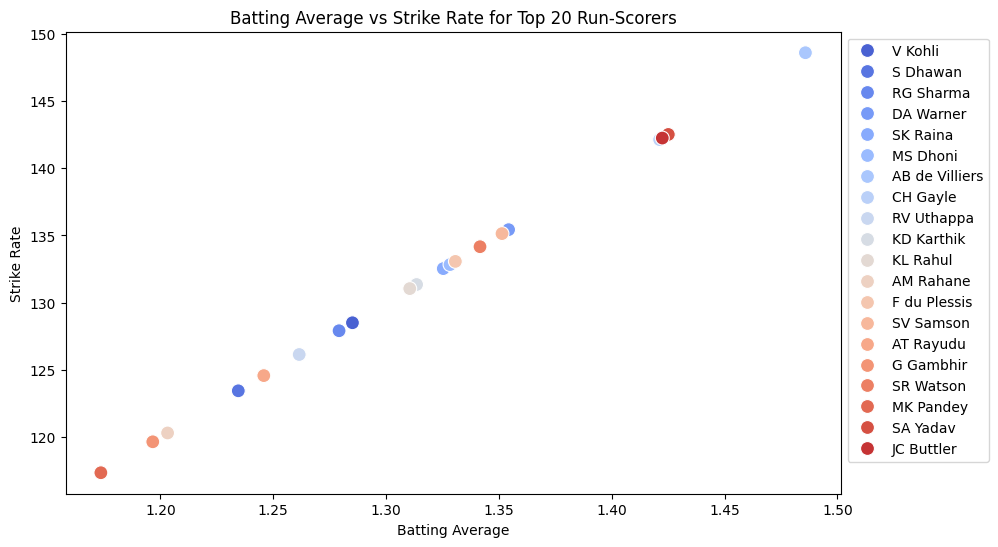


--------------------------------------------

Highest Batting Average: AB de Villiers - 1.4858044164037856
Highest Strike Rate: AB de Villiers - 148.58044164037855

--------------------------------------------



<ipython-input-37-967f2318f6ec>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_wicket_takers['bowler'], y=top_wicket_takers['player_dismissed'], palette='rocket')


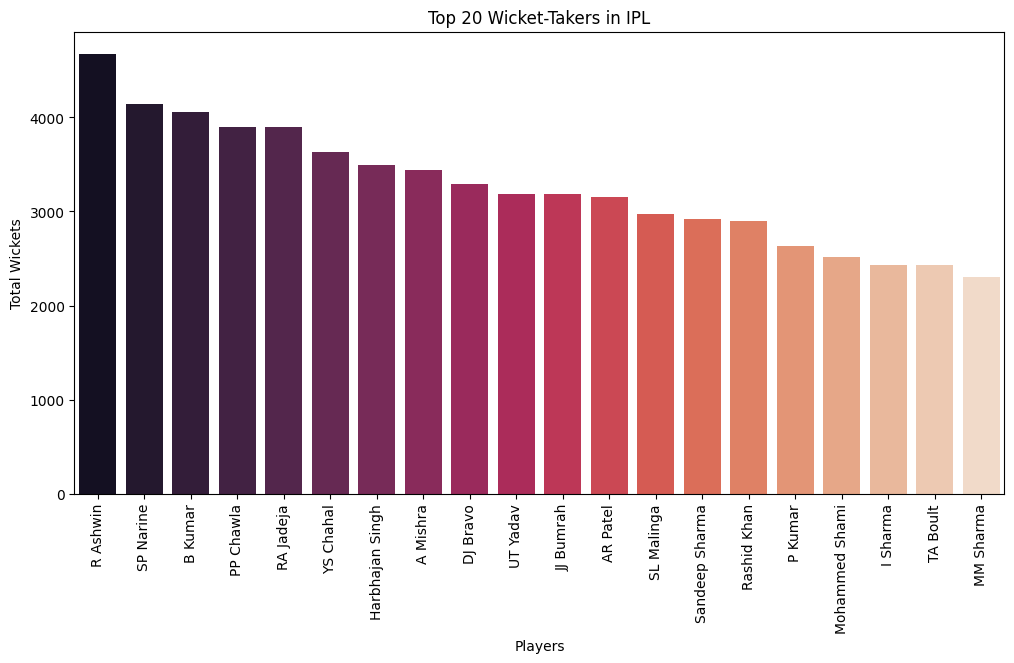

<ipython-input-37-967f2318f6ec>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=highest_scores['batter'], y=highest_scores['batsman_runs'], palette='plasma')


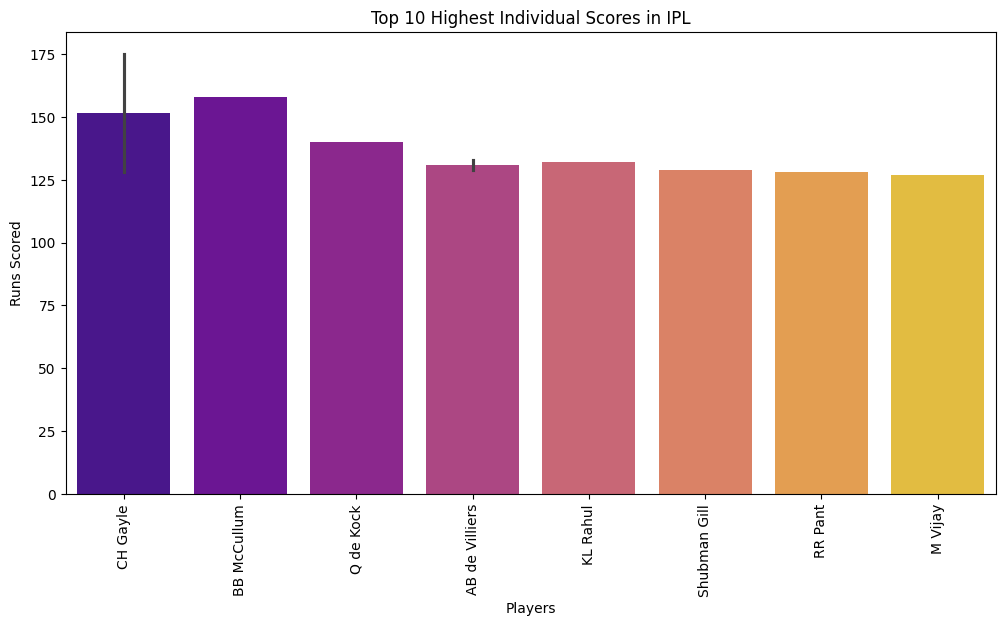

<ipython-input-37-967f2318f6ec>:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mom_counts.index, y=mom_counts.values, palette='viridis')


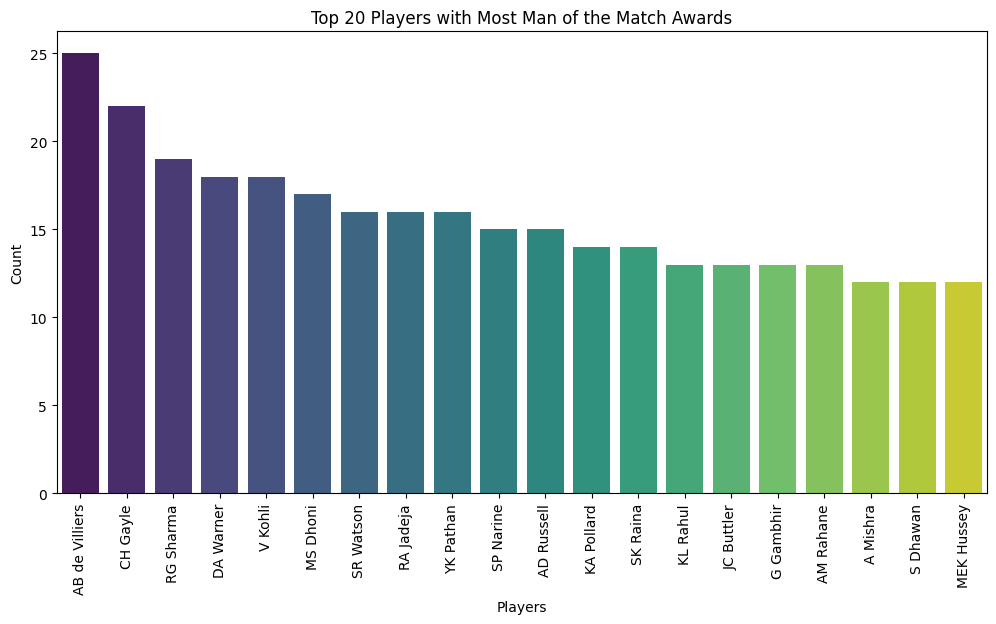

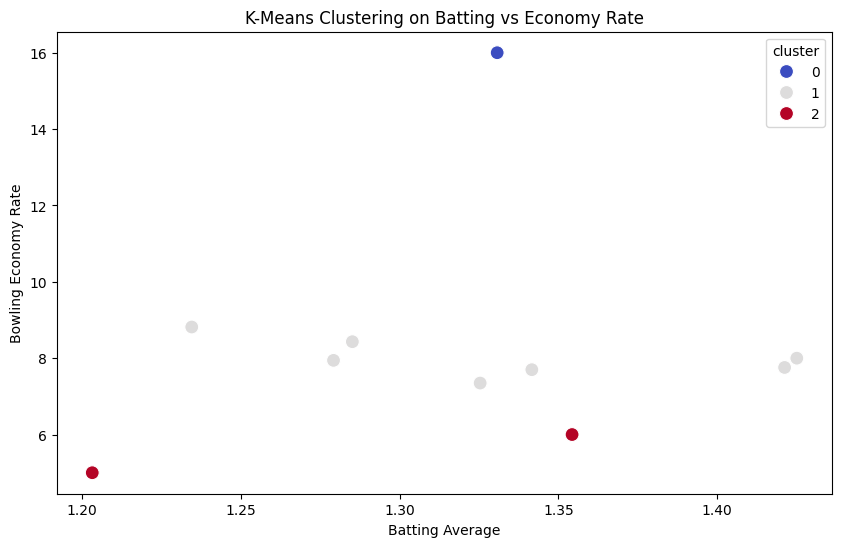

<ipython-input-37-967f2318f6ec>:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sixes.index, y=sixes.values, ax=axes[0, 0], palette='Blues')
<ipython-input-37-967f2318f6ec>:128: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(sixes.index, rotation=90)
<ipython-input-37-967f2318f6ec>:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fours.index, y=fours.values, ax=axes[0, 1], palette='Reds')
<ipython-input-37-967f2318f6ec>:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xtick

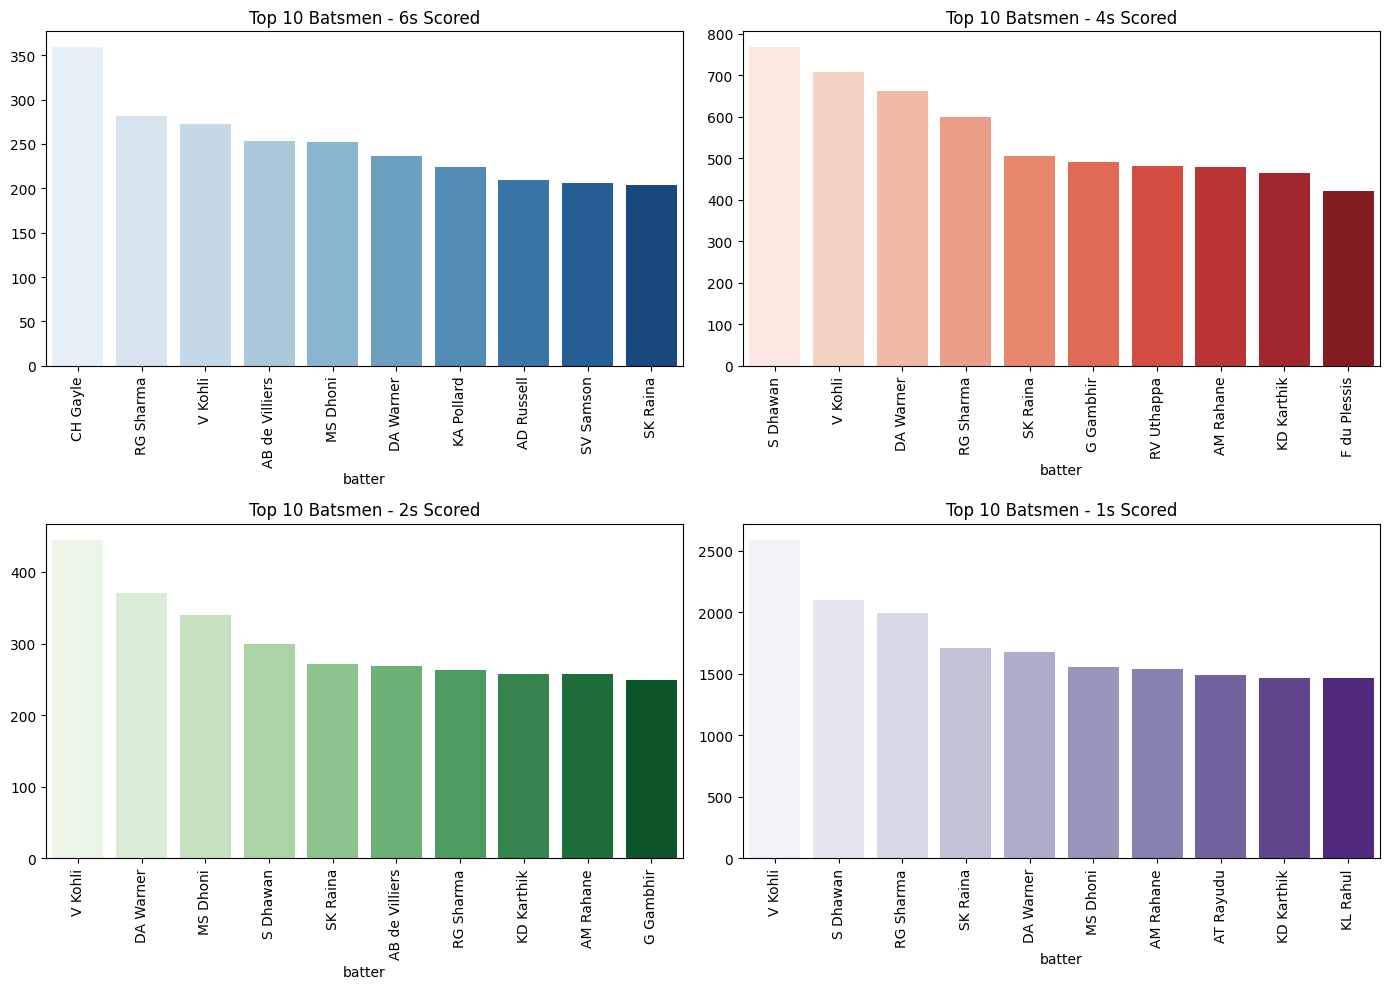

In [ ]:
# Group by batsman and sum total runs
top_scorers = deliveries.groupby('batter')['batsman_runs'].sum().reset_index()

# Sort by runs and get top 20
top_scorers = top_scorers.sort_values(by='batsman_runs', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_scorers['batter'], y=top_scorers['batsman_runs'], palette='magma')
plt.xticks(rotation=90)
plt.title("Top 20 Run Scorers in IPL")
plt.xlabel("Players")
plt.ylabel("Total Runs")
plt.show()


# Calculate batting average = Total Runs / (Total Outs)
batsman_outs = deliveries[deliveries['player_dismissed'].notnull()].groupby('batter').size()
top_scorers['outs'] = top_scorers['batter'].map(batsman_outs).fillna(1)  # Avoid division by zero
top_scorers['batting_average'] = top_scorers['batsman_runs'] / top_scorers['outs']

# Calculate strike rate = (Total Runs / Total Balls) * 100
balls_faced = deliveries.groupby('batter')['ball'].count()
top_scorers['strike_rate'] = (top_scorers['batsman_runs'] / top_scorers['batter'].map(balls_faced)) * 100

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_scorers, x='batting_average', y='strike_rate', hue='batter', s=100, palette='coolwarm')
plt.xlabel("Batting Average")
plt.ylabel("Strike Rate")
plt.title("Batting Average vs Strike Rate for Top 20 Run-Scorers")
plt.legend(bbox_to_anchor=(1,1))
plt.show()


# Count the number of matches played by each batsman
batsman_matches = deliveries.groupby('batter')['match_id'].nunique()

# Filter for players with more than 50 matches
qualified_batsmen = top_scorers[top_scorers['batter'].map(batsman_matches) > 50]

# Find highest average and strike rate
highest_avg = qualified_batsmen.loc[qualified_batsmen['batting_average'].idxmax()]
highest_sr = qualified_batsmen.loc[qualified_batsmen['strike_rate'].idxmax()]
print("\n--------------------------------------------\n")
print("Highest Batting Average:", highest_avg['batter'], "-", highest_avg['batting_average'])
print("Highest Strike Rate:", highest_sr['batter'], "-", highest_sr['strike_rate'])
print("\n--------------------------------------------\n")


# Count the number of wickets taken by each bowler
top_wicket_takers = deliveries[deliveries['player_dismissed'].notnull()].groupby('bowler')['player_dismissed'].count().reset_index()

# Sort and get top 20
top_wicket_takers = top_wicket_takers.sort_values(by='player_dismissed', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_wicket_takers['bowler'], y=top_wicket_takers['player_dismissed'], palette='rocket')
plt.xticks(rotation=90)
plt.title("Top 20 Wicket-Takers in IPL")
plt.xlabel("Players")
plt.ylabel("Total Wickets")
plt.show()


# Get highest individual innings scores
highest_scores = deliveries.groupby(['match_id', 'batter'])['batsman_runs'].sum().reset_index()

# Sort and get top 10
highest_scores = highest_scores.sort_values(by='batsman_runs', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=highest_scores['batter'], y=highest_scores['batsman_runs'], palette='plasma')
plt.xticks(rotation=90)
plt.title("Top 10 Highest Individual Scores in IPL")
plt.xlabel("Players")
plt.ylabel("Runs Scored")
plt.show()


# Count the number of times a player won 'Man of the Match'
mom_counts = matches['player_of_match'].value_counts().head(20)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=mom_counts.index, y=mom_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.title("Top 20 Players with Most Man of the Match Awards")
plt.xlabel("Players")
plt.ylabel("Count")
plt.show()

# Calculate economy rate = Runs Conceded / Overs Bowled
balls_bowled = deliveries.groupby('bowler')['ball'].count()
overs_bowled = balls_bowled / 6
runs_conceded = deliveries.groupby('bowler')['total_runs'].sum()
economy_rate = runs_conceded / overs_bowled

# Merge with batting data
players_stats = pd.DataFrame({'batting_average': top_scorers.set_index('batter')['batting_average'],
                              'economy_rate': economy_rate}).dropna()

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
players_stats['cluster'] = kmeans.fit_predict(players_stats)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=players_stats, x='batting_average', y='economy_rate', hue='cluster', palette='coolwarm', s=100)
plt.xlabel("Batting Average")
plt.ylabel("Bowling Economy Rate")
plt.title("K-Means Clustering on Batting vs Economy Rate")
plt.show()


# Count total 6s, 4s, 2s, and 1s scored by each batsman
sixes = deliveries[deliveries['batsman_runs'] == 6].groupby('batter').size().nlargest(10)
fours = deliveries[deliveries['batsman_runs'] == 4].groupby('batter').size().nlargest(10)
twos = deliveries[deliveries['batsman_runs'] == 2].groupby('batter').size().nlargest(10)
ones = deliveries[deliveries['batsman_runs'] == 1].groupby('batter').size().nlargest(10)

# Plot all together
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.barplot(x=sixes.index, y=sixes.values, ax=axes[0, 0], palette='Blues')
axes[0, 0].set_title("Top 10 Batsmen - 6s Scored")
axes[0, 0].set_xticklabels(sixes.index, rotation=90)

sns.barplot(x=fours.index, y=fours.values, ax=axes[0, 1], palette='Reds')
axes[0, 1].set_title("Top 10 Batsmen - 4s Scored")
axes[0, 1].set_xticklabels(fours.index, rotation=90)

sns.barplot(x=twos.index, y=twos.values, ax=axes[1, 0], palette='Greens')
axes[1, 0].set_title("Top 10 Batsmen - 2s Scored")
axes[1, 0].set_xticklabels(twos.index, rotation=90)

sns.barplot(x=ones.index, y=ones.values, ax=axes[1, 1], palette='Purples')
axes[1, 1].set_title("Top 10 Batsmen - 1s Scored")
axes[1, 1].set_xticklabels(ones.index, rotation=90)

plt.tight_layout()
plt.show()




*   Seasonal Anlysis



In [ ]:
# Merge deliveries with matches to get season info
match_runs = deliveries.groupby("match_id")["total_runs"].sum().reset_index()
match_runs = match_runs.merge(matches[["id", "season"]], left_on="match_id", right_on="id").drop(columns=["id"])

# Calculate average runs per match per season
avg_runs_per_season = match_runs.groupby("season")["total_runs"].mean().reset_index()
print("\n------------------------------------------\n")
print("Average Runs per Match per Season:")
print(avg_runs_per_season)
print("\n------------------------------------------\n")


# Count number of matches with target > 200 per season
high_targets = matches[matches["target_runs"] > 200].groupby("season").size().reset_index(name="200+ Targets")
print("\n------------------------------------------\n")
print("Targets of 200+ Runs per Season:")
print(high_targets)
print("\n------------------------------------------\n")

# Merge deliveries and matches
team_season_scores = deliveries.groupby(["match_id", "batting_team"])["total_runs"].sum().reset_index()
team_season_scores = team_season_scores.merge(matches[["id", "season"]], left_on="match_id", right_on="id").drop(columns=["id"])

# Calculate average score per team per season
avg_team_scores = team_season_scores.groupby(["season", "batting_team"])["total_runs"].mean().reset_index()
print("\n------------------------------------------\n")
print("Average Score of Each Team Per Season:")
print(avg_team_scores)
print("\n------------------------------------------\n")

# Merge deliveries with matches to get season information
deliveries_season = deliveries.merge(matches[["id", "season"]], left_on="match_id", right_on="id").drop(columns=["id"])

# Calculate total runs per batsman per season
orange_cap = deliveries_season.groupby(["season", "batter"])["batsman_runs"].sum().reset_index()

# Find the highest run scorer per season
orange_cap = orange_cap.sort_values(["season", "batsman_runs"], ascending=[True, False]).drop_duplicates("season")
print("\n------------------------------------------\n")
print("Orange Cap Holders (Highest Run-Scorers Per Season):")
print(orange_cap)
print("\n------------------------------------------\n")

# Merge deliveries with matches to get season information
deliveries_season = deliveries.merge(matches[["id", "season"]], left_on="match_id", right_on="id").drop(columns=["id"])

# Identify Purple Cap Holders (Highest Wicket-Taker per Season)
purple_cap = deliveries_season[deliveries_season["is_wicket"] == 1].groupby(["season", "bowler"]).size().reset_index(name="wickets")
purple_cap = purple_cap.sort_values(["season", "wickets"], ascending=[True, False]).drop_duplicates("season")
print("\n------------------------------------------\n")
print("Purple Cap Holders (Highest Wicket-Takers Per Season):")
print(purple_cap)
print("\n------------------------------------------\n")

# Find top 10 bowlers per season
top_bowlers_per_season = deliveries_season[deliveries_season["is_wicket"] == 1].groupby(["season", "bowler"]).size().reset_index(name="wickets")
top_bowlers_per_season = top_bowlers_per_season.sort_values(["season", "wickets"], ascending=[True, False])

# Select top 10 per season
top_10_bowlers = top_bowlers_per_season.groupby("season").head(10)
print("\n------------------------------------------\n")
print("Top 10 Bowlers Per Season:")
print(top_10_bowlers)
print("\n------------------------------------------\n")



------------------------------------------

Average Runs per Match per Season:
     season  total_runs
0   2007/08  309.258621
1      2009  286.894737
2   2009/10  314.716667
3      2011  293.027778
4      2012  303.418919
5      2013  297.394737
6      2014  315.516667
7      2015  312.982759
8      2016  314.366667
9      2017  318.406780
10     2018  331.683333
11     2019  323.900000
12  2020/21  323.600000
13     2021  310.616667
14     2022  329.662162
15     2023  350.178082
16     2024  365.788732

------------------------------------------


------------------------------------------

Targets of 200+ Runs per Season:
     season  200+ Targets
0   2007/08             7
1      2009             1
2   2009/10             5
3      2011             4
4      2012             4
5      2013             4
6      2014             5
7      2015             6
8      2016             5
9      2017             8
10     2018            11
11     2019             8
12  2020/21             9
1

4.  Feature Extraction

In [ ]:
#removing unneccesary columns for better prediction
deli= deliveries.drop(columns=['non_striker', 'extras_type', 'player_dismissed', 'fielder'])
mat = matches.drop(columns=['match_type', 'player_of_match', 'result', 'target_runs', 'target_overs', 'umpire1', 'umpire2'])

In [ ]:
deli.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batter', 'bowler', 'batsman_runs', 'extra_runs', 'total_runs',
       'is_wicket', 'dismissal_kind'],
      dtype='object')

In [ ]:
mat.columns

Index(['id', 'season', 'city', 'date', 'venue', 'team1', 'team2',
       'toss_winner', 'toss_decision', 'winner', 'result_margin', 'super_over',
       'result_margin_log'],
      dtype='object')

In [ ]:

matches['date'] = pd.to_datetime(matches['date'])
matches['win_margin_log'] = np.log1p(matches['result_margin'])  # Log transformation for outliers
matches['toss_decision_flag'] = matches['toss_decision'].apply(lambda x: 1 if x == 'bat' else 0)

# Define home cities for teams
team_home_cities = {
    'Chennai Super Kings': 'Chennai',
    'Mumbai Indians': 'Mumbai',
    'Royal Challengers Bangalore': 'Bangalore',
    'Kolkata Knight Riders': 'Kolkata',
    'Rajasthan Royals': 'Jaipur',
    'Sunrisers Hyderabad': 'Hyderabad',
    'Delhi Capitals': 'Delhi',
    'Punjab Kings': 'Mohali',
    'Gujarat Titans': 'Ahmedabad',
    'Lucknow Super Giants': 'Lucknow'
}

# Function to check home advantage
def home_advantage(team, city):
    return 1 if team_home_cities.get(team, '') == city else 0

matches['home_advantage_team1'] = matches.apply(lambda x: home_advantage(x['team1'], x['city']), axis=1)
matches['home_advantage_team2'] = matches.apply(lambda x: home_advantage(x['team2'], x['city']), axis=1)
matches['home_advantage'] = matches[['home_advantage_team1', 'home_advantage_team2']].max(axis=1)

# Keep only important match features
match_features = matches[['id', 'season', 'venue', 'team1', 'team2', 'toss_winner',
                          'toss_decision_flag', 'home_advantage', 'win_margin_log', 'winner']]

deliveries['is_boundary'] = deliveries['batsman_runs'].apply(lambda x: 1 if x in [4, 6] else 0)
deliveries['is_dot_ball'] = deliveries['total_runs'].apply(lambda x: 1 if x == 0 else 0)

# Define Powerplay and Death Overs
deliveries['over_category'] = deliveries['over'].apply(lambda x: 'Powerplay' if x <= 6 else ('Death' if x >= 16 else 'Middle'))

# Group by match and team
team_stats = deliveries.groupby(['match_id', 'batting_team']).agg(
    total_runs=('total_runs', 'sum'),
    boundaries=('is_boundary', 'sum'),
    dot_balls=('is_dot_ball', 'sum'),
    total_wickets=('is_wicket', 'sum'),
    total_balls=('ball', 'count')
).reset_index()

# Compute Run Rate and Economy Rate
team_stats['run_rate'] = team_stats['total_runs'] / (team_stats['total_balls'] / 6)
team_stats['economy_rate'] = (team_stats['total_runs'] / team_stats['total_balls']) * 6

# Powerplay and Death Overs Stats
powerplay_stats = deliveries[deliveries['over'] <= 6].groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()
powerplay_stats.rename(columns={'total_runs': 'powerplay_runs'}, inplace=True)

death_over_stats = deliveries[deliveries['over'] >= 16].groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()
death_over_stats.rename(columns={'total_runs': 'death_over_runs'}, inplace=True)

# Merge Powerplay and Death Overs Stats
team_stats = team_stats.merge(powerplay_stats, on=['match_id', 'batting_team'], how='left')
team_stats = team_stats.merge(death_over_stats, on=['match_id', 'batting_team'], how='left')

team_stats.fillna(0, inplace=True)

final_data = match_features.merge(team_stats, left_on=['id', 'team1'], right_on=['match_id', 'batting_team'], how='left')

# Rename columns for clarity
final_data.rename(columns={
    'total_runs': 'team1_total_runs',
    'boundaries': 'team1_boundaries',
    'dot_balls': 'team1_dot_balls',
    'total_wickets': 'team1_wickets',
    'run_rate': 'team1_run_rate',
    'economy_rate': 'team1_economy_rate',
    'powerplay_runs': 'team1_powerplay_runs',
    'death_over_runs': 'team1_death_over_runs'
}, inplace=True)

# Repeat for team2
team2_stats = team_stats.rename(columns={
    'batting_team': 'team2',
    'total_runs': 'team2_total_runs',
    'boundaries': 'team2_boundaries',
    'dot_balls': 'team2_dot_balls',
    'total_wickets': 'team2_wickets',
    'run_rate': 'team2_run_rate',
    'economy_rate': 'team2_economy_rate',
    'powerplay_runs': 'team2_powerplay_runs',
    'death_over_runs': 'team2_death_over_runs'
})

final_data = final_data.merge(team2_stats, left_on=['id', 'team2'], right_on=['match_id', 'team2'], how='left')

# Drop redundant columns
final_data.drop(['match_id_x', 'match_id_y', 'batting_team_x', 'batting_team_y'], axis=1, errors='ignore', inplace=True)


In [ ]:
final_data.columns

Index(['id', 'season', 'venue', 'team1', 'team2', 'toss_winner',
       'toss_decision_flag', 'home_advantage', 'win_margin_log', 'winner',
       'batting_team', 'team1_total_runs', 'team1_boundaries',
       'team1_dot_balls', 'team1_wickets', 'total_balls_x', 'team1_run_rate',
       'team1_economy_rate', 'team1_powerplay_runs', 'team1_death_over_runs',
       'team2_total_runs', 'team2_boundaries', 'team2_dot_balls',
       'team2_wickets', 'total_balls_y', 'team2_run_rate',
       'team2_economy_rate', 'team2_powerplay_runs', 'team2_death_over_runs'],
      dtype='object')

In [ ]:
final_data.drop(['id','venue'],axis=1,inplace=True)

In [ ]:
# Convert season to an integer (take only the first four characters)
final_data['season'] = final_data['season'].astype(str).str[:4].astype(int)


In [ ]:
final_data.dtypes

,0
season,int64
team1,object
team2,object
toss_winner,object
toss_decision_flag,int64
home_advantage,int64
win_margin_log,float64
winner,object
batting_team,object
team1_total_runs,int64


5. Model Training

Random Forest Accuracy: 0.9543
XGBoost Accuracy: 0.9726
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7260 - loss: 0.5614
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8333 - loss: 0.3608
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8842 - loss: 0.2787
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9186 - loss: 0.2116
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9265 - loss: 0.1896
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9319 - loss: 0.1604
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9536 - loss: 0.1424
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9457 - loss: 0.1478
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9406 - loss: 0.1357
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9527 - loss: 0.1172
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9709 - loss: 0.0920
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9642 - loss: 0.0896


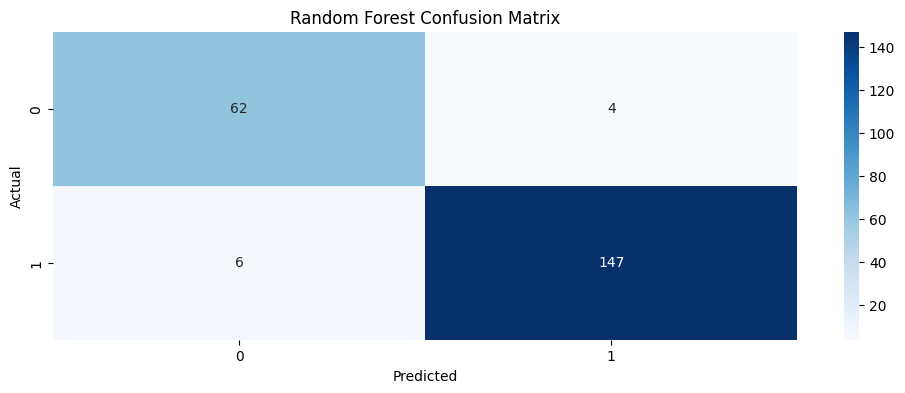

In [ ]:

encoder = LabelEncoder()
categorical_cols = ['team1', 'team2', 'toss_winner', 'winner','batting_team']

for col in categorical_cols:
    final_data[col] = encoder.fit_transform(final_data[col])

X = final_data.drop(columns=['winner_binary'])  # Features
y = final_data['winner_binary']  # Target Variable (Winner)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize Numerical Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
print(f"Random Forest Accuracy: {rf_acc:.4f}")

# XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_preds)
print(f"XGBoost Accuracy: {xgb_acc:.4f}")

# Neural Network
nn_model = Sequential([
    Dense(64, activation='tanh', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='tanh'),
    Dense(len(final_data['winner_binary'].unique()), activation='softmax')  # Output Layer
])

nn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)
nn_preds = np.argmax(nn_model.predict(X_test), axis=1)
nn_acc = accuracy_score(y_test, nn_preds)
print(f"Neural Network Accuracy: {nn_acc:.4f}")

# Evaluate Models
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))
print("\nXGBoost Classification Report:\n", classification_report(y_test, xgb_preds))
print("\nNeural Network Classification Report:\n", classification_report(y_test, nn_preds))

# Confusion Matrix Plot
plt.figure(figsize=(12, 4))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Convert 'winner' to binary (0 = Team1, 1 = Team2)
final_data['winner_binary'] = final_data.apply(lambda x: 0 if x['winner'] == x['team1'] else 1, axis=1)

# Define Features (X) and Target (y)
X = final_data.drop(columns=['winner', 'winner_binary'])  # Drop categorical 'winner'
y = final_data['winner_binary']  # Use binary labels (0 or 1)


In [ ]:
df = final_data.copy()

categorical_cols = ['team1', 'team2',  'toss_winner', 'winner','batting_team']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# X = df.drop(columns=[ 'winner'])
# y = df['winner']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
rf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
xgb = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss')

knn.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6027 - loss: 0.6630 - val_accuracy: 0.8676 - val_loss: 0.3993
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7758 - loss: 0.4846 - val_accuracy: 0.9224 - val_loss: 0.2804
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8461 - loss: 0.3576 - val_accuracy: 0.9132 - val_loss: 0.2296
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8789 - loss: 0.2842 - val_accuracy: 0.9315 - val_loss: 0.1838
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9086 - loss: 0.2417 - val_accuracy: 0.9406 - val_loss: 0.1601
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9163 - loss: 0.2333 - val_accuracy: 0.9680 - val_loss: 0.1323
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9341 - loss: 0.2080 - val_accuracy: 0.9680 - val_loss: 0.1221
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9333 - loss: 0.1833 - val_accuracy: 0.9726 - val_loss: 0.1022
Ep

In [ ]:
from sklearn.linear_model import LogisticRegression
#  Hard Voting (Majority Voting)
hard_voting_clf = VotingClassifier(estimators=[
    ('knn', knn), ('rf', rf), ('xgb', xgb)
], voting='hard')

hard_voting_clf.fit(X_train, y_train)
y_pred_hard = hard_voting_clf.predict(X_test)
accuracy_hard = accuracy_score(y_test, y_pred_hard)

#  Soft Voting (Weighted Probability Voting)
soft_voting_clf = VotingClassifier(estimators=[
    ('knn', knn), ('rf', rf), ('xgb', xgb)
], voting='soft')

soft_voting_clf.fit(X_train, y_train)
y_pred_soft = soft_voting_clf.predict(X_test)
accuracy_soft = accuracy_score(y_test, y_pred_soft)


stacking_clf = StackingClassifier(
    estimators=[('knn', knn), ('rf', rf), ('xgb', xgb)],
    final_estimator=LogisticRegression(),
    cv=5
)

stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)

# Use Neural Network Predictions as Additional Features
y_pred_nn_train = np.argmax(nn_model.predict(X_train), axis=1)
y_pred_nn_test = np.argmax(nn_model.predict(X_test), axis=1)

# Combine Neural Network Predictions with Other Models
X_train_ensemble = np.column_stack((y_pred_nn_train, knn.predict(X_train), rf.predict(X_train), xgb.predict(X_train)))
X_test_ensemble = np.column_stack((y_pred_nn_test, knn.predict(X_test), rf.predict(X_test), xgb.predict(X_test)))

# Train Stacking with Neural Network Predictions
stacking_nn_clf = StackingClassifier(
    estimators=[('knn', knn), ('rf', rf), ('xgb', xgb)],
    final_estimator=LogisticRegression(),
    cv=5
)

stacking_nn_clf.fit(X_train_ensemble, y_train)
y_pred_stacking_nn = stacking_nn_clf.predict(X_test_ensemble)
accuracy_stacking_nn = accuracy_score(y_test, y_pred_stacking_nn)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:07:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# **Compare All Models**
print("\nModel Comparison:")
print(f"KNN Accuracy: {accuracy_score(y_test, knn.predict(X_test)):.4f}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf.predict(X_test)):.4f}")
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb.predict(X_test)):.4f}")
print(f"Neural Network Accuracy: {accuracy_score(y_test, y_pred_nn_test):.4f}")
print(f"Hard Voting Ensemble Accuracy: {accuracy_hard:.4f}")
print(f"Soft Voting Ensemble Accuracy: {accuracy_soft:.4f}")
print(f"Stacking Ensemble Accuracy: {accuracy_stacking:.4f}")
print(f"Stacking + Neural Network Accuracy: {accuracy_stacking_nn:.4f}")

# **Classification Report**
print("\n Classification Report for Best Model:")
print(classification_report(y_test, y_pred_stacking_nn))



Model Comparison:
KNN Accuracy: 0.9087
Random Forest Accuracy: 0.9680
XGBoost Accuracy: 0.9726
Neural Network Accuracy: 0.9772
Hard Voting Ensemble Accuracy: 0.9772
Soft Voting Ensemble Accuracy: 0.9772
Stacking Ensemble Accuracy: 0.9772
Stacking + Neural Network Accuracy: 0.9726

 Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        66
           1       0.99      0.97      0.98       153

    accuracy                           0.97       219
   macro avg       0.96      0.97      0.97       219
weighted avg       0.97      0.97      0.97       219



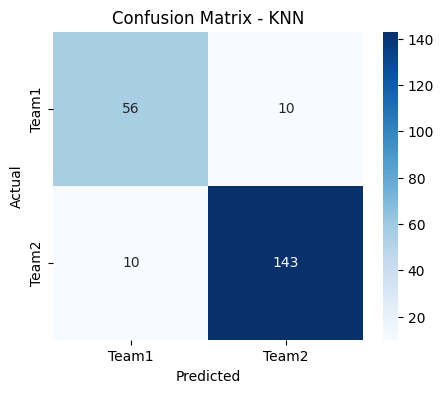

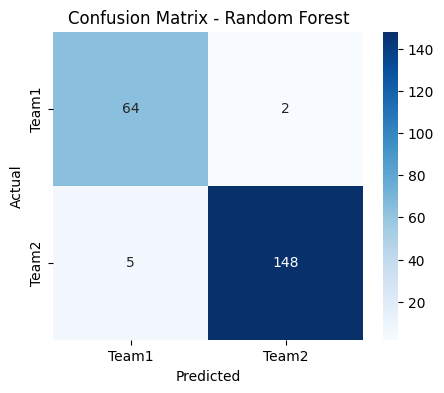

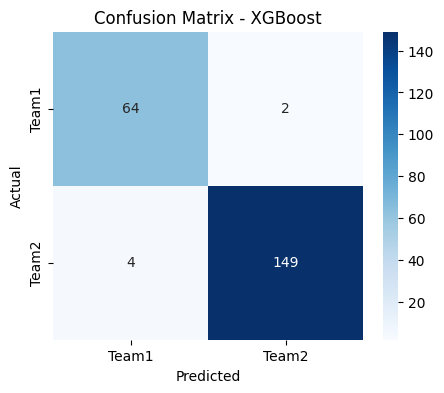

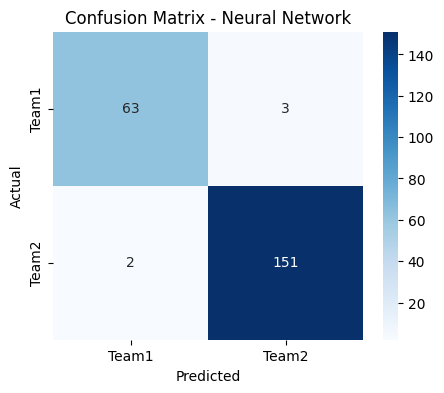

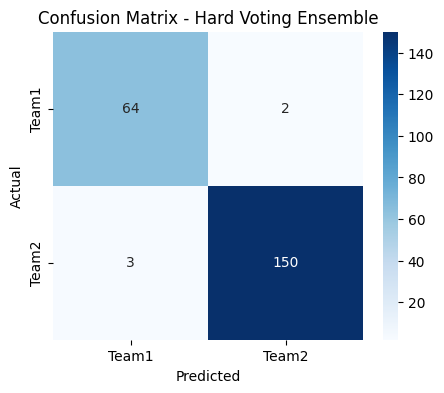

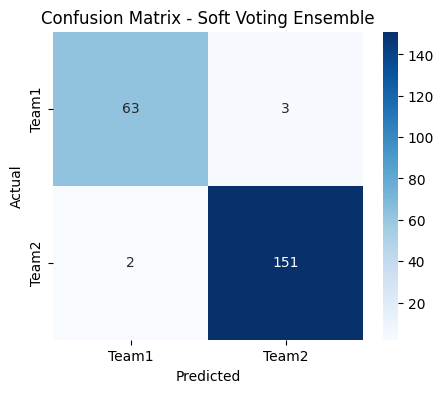

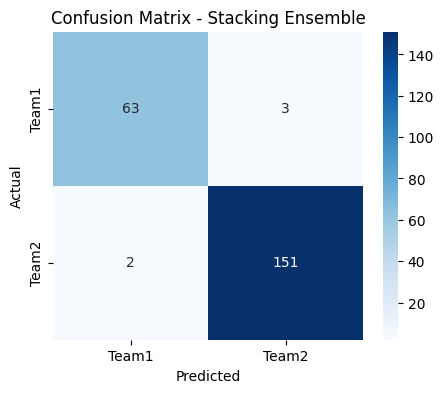

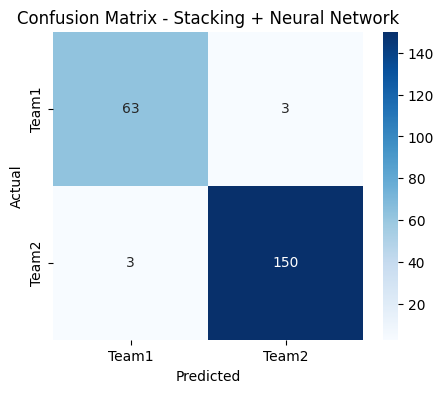

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Team1", "Team2"], yticklabels=["Team1", "Team2"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# **Plot Confusion Matrices for Each Model**
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN")
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest")
plot_confusion_matrix(y_test, xgb.predict(X_test), "XGBoost")
plot_confusion_matrix(y_test, y_pred_nn_test, "Neural Network")
plot_confusion_matrix(y_test, y_pred_hard, "Hard Voting Ensemble")
plot_confusion_matrix(y_test, y_pred_soft, "Soft Voting Ensemble")
plot_confusion_matrix(y_test, y_pred_stacking, "Stacking Ensemble")
plot_confusion_matrix(y_test, y_pred_stacking_nn, "Stacking + Neural Network")


In [ ]:

knn = KNeighborsClassifier()
knn_params = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}

rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 300, 500], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10]}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_params = {'n_estimators': [100, 300, 500], 'max_depth': [3, 6, 9], 'learning_rate': [0.01, 0.1, 0.2]}

# Grid Search for All Models
models = {'KNN': (knn, knn_params), 'Random Forest': (rf, rf_params), 'XGBoost': (xgb, xgb_params)}
best_models = {}

for model_name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_

    print(f"Best {model_name} Model: {grid_search.best_params_}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best KNN Model: {'n_neighbors': 9, 'weights': 'uniform'}
Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

In [ ]:

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n {model_name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))


In [ ]:
# Best Hyperparameters from Grid Search
best_params = {
    'n_estimators': 700,
    'max_depth': 9,
    'learning_rate': 0.04,
    'colsample_bytree': 0.5,
    'subsample': 0.8,
    'gamma': 0.05,
    'min_child_weight': 3,
    'num_class': len(y.unique())
}

xgb_model = XGBClassifier(**best_params,label_encoders=False,eval_metric = 'mlogloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f" XGBoost Accuracy: {accuracy_xgb:.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:10:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "label_encoders" } are not used.

  warnings.warn(smsg, UserWarning)


 XGBoost Accuracy: 0.9772

 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96        66
           1       0.99      0.98      0.98       153

    accuracy                           0.98       219
   macro avg       0.97      0.98      0.97       219
weighted avg       0.98      0.98      0.98       219



In [ ]:
# prompt: code to dump model using joblib

import joblib

# Assuming 'xgb_model' is your trained XGBoost model
joblib.dump(xgb_model, 'xgb_model.joblib')
